## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('0948b6427e46bb1bc7fa60b52df96ab0080b9d4ff80209a5fee99277')
debug = False
from datetime import datetime 
pro = ts.pro_api()

In [2]:
# !pip install openpyxl

## 生成Alpha因子的基础函数

In [3]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
        return alpha_dict
        

## 生成训练集

In [59]:
import pandas as pd
price_PD_total = pd.read_csv('./data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = pro.stock_basic()
all_stock = all_stock[['ts_code','name','market']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount']]



In [60]:
indus = pd.read_csv('./data/a_stock_industry.csv',encoding='gbk')
indus = indus[['windcode','申万行业L1','申万行业L2','申万行业L3']]
indus.columns = ['ts_code','indus1','indus2','indus3']
indus.head()

,ts_code,indus1,indus2,indus3
0,000001.SZ,银行,银行Ⅱ,银行Ⅲ
1,000002.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ
2,000004.SZ,计算机,计算机应用,IT服务
3,000005.SZ,公用事业,环保工程及服务Ⅱ,环保工程及服务Ⅲ
4,000006.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ


In [61]:
##拼接行业，只保留主板、中小板、创业板，去除ST股票
price_PD_total = pd.merge(price_PD_total,indus,how='left',on='ts_code')
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)
price_PD_total.head()

,ts_code,name,market,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,indus1,indus2,indus3
0,000001.SZ,平安银行,主板,20150105,10.1514,10.3355,9.9038,10.1704,10.0562,0.1142,1.1356,2860436.43,4.565388e+06,银行,银行Ⅱ,银行Ⅲ
1,000001.SZ,平安银行,主板,20150106,10.0625,10.4053,9.8720,10.0181,10.1704,-0.1523,-1.4975,2166421.40,3.453446e+06,银行,银行Ⅱ,银行Ⅲ
2,000001.SZ,平安银行,主板,20150107,9.8784,10.0498,9.7133,9.8276,10.0181,-0.1905,-1.9016,1700120.67,2.634796e+06,银行,银行Ⅱ,银行Ⅲ
3,000001.SZ,平安银行,主板,20150108,9.8403,9.8847,9.4594,9.4975,9.8276,-0.3301,-3.3589,1407714.21,2.128003e+06,银行,银行Ⅱ,银行Ⅲ
4,000001.SZ,平安银行,主板,20150109,9.4594,10.0752,9.3388,9.5737,9.4975,0.0762,0.8023,2508500.23,3.835378e+06,银行,银行Ⅱ,银行Ⅲ


In [62]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [63]:
#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [10]:
price_PD_wfq = pd.read_csv('./data/price_PD_2015至今_未复权.csv')
price_PD_wfq.trade_date = price_PD_wfq.trade_date.astype('str')
price_PD_wfq = price_PD_wfq.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
price_PD_wfq['vwap'] = price_PD_wfq.amount/price_PD_wfq.vol
price_PD_wfq = price_PD_wfq[price_PD_wfq.ts_code.isin(price_PD_total.ts_code.unique())]
price_PD_wfq.tail()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,vwap
6220326,605599.SH,20220909,10.09,10.22,9.22,10.02,10.22,-0.20,-1.9569,58236.31,57322.643,0.984311
6220327,605599.SH,20220913,9.79,10.08,9.79,9.98,10.02,-0.04,-0.3992,31553.39,31488.568,0.997946
6220328,605599.SH,20220914,9.90,9.92,9.77,9.85,9.98,-0.13,-1.3026,18402.20,18093.121,0.983204
6220329,605599.SH,20220915,9.89,9.89,9.61,9.69,9.85,-0.16,-1.6244,14409.77,14020.617,0.972994
6220330,605599.SH,20220916,9.64,9.70,9.38,9.41,9.69,-0.28,-2.8896,14882.43,14157.309,0.951277


In [11]:
daily_info = {}
daily_info['open'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'open')
daily_info['close'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'close')
daily_info['high']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'high')
daily_info['low']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'low')
daily_info['amount']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'amount')
daily_info['volume']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'vol')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 



In [12]:
del price_PD_wfq

In [13]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [14]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:25<00:00,  3.44s/it]


In [15]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [16]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'indus1',
       'indus2', 'indus3', 'open_up', 'ret1', 'ret2', 'ret'],
      dtype='object')

In [17]:
# del price_PD_total

In [18]:
data.head()

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha29,alpha30,alpha31,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up
0,000001.SZ,20150105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,平安银行,0.985025,0.976656,0.976656,NaN
1,000001.SZ,20150106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.336207,NaN,平安银行,0.980984,0.961441,0.961441,1.013306
2,000001.SZ,20150107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.583333,NaN,平安银行,0.966411,0.972907,0.972907,1.023902
3,000001.SZ,20150108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.450549,1.421053,NaN,平安银行,1.008023,0.991279,0.991279,1.040105
4,000001.SZ,20150109,NaN,0.005111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.538462,17.142857,2.552632,NaN,平安银行,0.979444,0.987225,0.987225,1.027847


In [21]:
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

In [23]:
fields = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005']


In [24]:
data

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha29,alpha30,alpha31,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up
0,000001.SZ,20150105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,平安银行,0.985025,0.976656,0.976656,NaN
1,000001.SZ,20150106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.336207,NaN,平安银行,0.980984,0.961441,0.961441,1.013306
2,000001.SZ,20150107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.583333,NaN,平安银行,0.966411,0.972907,0.972907,1.023902
3,000001.SZ,20150108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.450549,1.421053,NaN,平安银行,1.008023,0.991279,0.991279,1.040105
4,000001.SZ,20150109,NaN,0.005111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.538462,17.142857,2.552632,NaN,平安银行,0.979444,0.987225,0.987225,1.027847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7518435,605599.SH,20220909,-1.164040e-06,0.000029,-1.472077e-07,-8.546963e-08,-0.000011,0.000014,3.328222e-07,0.000019,...,10.555556,1.316832,inf,16.295858,-0.368160,菜百股份,0.996008,1.006129,1.006129,1.007984
7518436,605599.SH,20220913,-7.095527e-07,0.000036,-2.449270e-07,-8.627016e-08,-0.000012,0.000012,3.359395e-07,0.000019,...,12.033333,2.850000,inf,9.034615,-0.086707,菜百股份,0.986974,0.978788,0.978788,1.011022
7518437,605599.SH,20220914,-6.850260e-07,0.000043,-3.723649e-07,-9.329077e-08,-0.000012,0.000013,3.632781e-07,0.000021,...,9.138095,2.812500,inf,6.525000,-0.192648,菜百股份,0.983756,0.951466,0.951466,0.993909
7518438,605599.SH,20220915,-6.008326e-07,0.000035,-3.804300e-07,-7.280125e-08,-0.000010,0.000010,2.834910e-07,0.000016,...,9.950739,2.011494,inf,inf,-0.162002,菜百股份,0.971104,NaN,NaN,1.021672


In [25]:
train = data.copy()
train = train[train.trade_date < '20200401']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import KFold,GroupKFold,train_test_split

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

enumsplit = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind[int(0.025*len(trn_ind)):int(0.975*len(trn_ind))], val_ind])   ##避免泄露
    enumsplit.append([trn_ind, val_ind])  ##数据存在一点点泄露
enumsplit

[[array([      0,       1,       2, ..., 3599947, 3599948, 3599949]),
  array([     12,      13,      19, ..., 3599918, 3599933, 3599942])],
 [array([      3,       4,       6, ..., 3599945, 3599947, 3599948]),
  array([      0,       1,       2, ..., 3599943, 3599946, 3599949])],
 [array([      0,       1,       2, ..., 3599946, 3599948, 3599949]),
  array([      3,      18,      23, ..., 3599944, 3599945, 3599947])],
 [array([      0,       1,       2, ..., 3599946, 3599947, 3599949]),
  array([      6,      10,      14, ..., 3599940, 3599941, 3599948])],
 [array([      0,       1,       2, ..., 3599947, 3599948, 3599949]),
  array([      4,       8,      15, ..., 3599920, 3599925, 3599928])]]

In [26]:
X_train = np.nan_to_num(train[fields])
y_train = np.nan_to_num(train['ret_rank'])

## 模型训练

In [28]:
function_set = ['add', 'sub', 'mul', 'div','sqrt', 'log','inv','sin','max','min']
population_size = 1000
generations = 2
random_state= 42
est_gp = SymbolicTransformer(
                            feature_names=fields, 
                            function_set=function_set,
                            generations=generations,
#                             metric=my_metric,
                            population_size=population_size,
                            tournament_size=30, 
                            random_state=random_state,
                            verbose=2, hall_of_fame=100,
                            parsimony_coefficient=0.0001,
                            p_crossover = 0.4,
                            p_subtree_mutation = 0.01,
                            p_hoist_mutation = 0,
                            p_point_mutation = 0.01,
                            p_point_replace = 0.4,
                            n_jobs = 8)
     

est_gp.fit(X_train, y_train)

C:\Users\86156\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.8min remaining:  5.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished


   0    11.02        0.0082173        5        0.0473819              N/A      1.85m


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.5min remaining:  4.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.5min finished


   1     6.08        0.0315775        5        0.0473819              N/A      0.00s


SymbolicTransformer(feature_names=['alpha01', 'alpha02', 'alpha06', 'alpha07',
                                   'alpha08', 'alpha09', 'alpha10', 'alpha12',
                                   'alpha13', 'alpha14', 'alpha15', 'alpha16',
                                   'alpha17', 'alpha18', 'alpha19', 'alpha20',
                                   'alpha21', 'alpha23', 'alpha24', 'alpha28',
                                   'alpha29', 'alpha30', 'alpha31', 'alpha32',
                                   'alpha_w_005'],
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'sin', 'max', 'min'],
                    generations=2, n_jobs=8, p_crossover=0.4,
                    p_hoist_mutation=0, p_point_replace=0.4,
                    parsimony_coefficient=0.0001, random_state=42,
                    tournament_size=30, verbose=2)

In [29]:
best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}
     
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
best_programs_dict

,fitness,expression,depth,length
alpha_10,0.04081,"add(log(sqrt(inv(alpha06))), log(alpha16))",4,7
alpha_9,0.040911,"add(alpha06, add(log(alpha16), alpha10))",3,6
alpha_8,0.042228,"sqrt(div(div(sin(alpha18), inv(-0.597)), sub(a...",4,13
alpha_5,0.044048,"add(sqrt(min(inv(alpha23), alpha01)), log(alph...",4,8
alpha_4,0.044266,"add(sin(sin(alpha13)), log(alpha14))",3,6
alpha_6,0.044336,"add(sin(alpha02), log(alpha14))",2,5
alpha_2,0.044584,"sub(mul(log(sqrt(alpha12)), max(sub(alpha08, a...",4,19
alpha_7,0.044635,log(alpha14),1,2
alpha_3,0.044911,"max(sqrt(log(inv(alpha24))), inv(add(div(alpha...",4,12
alpha_1,0.046882,"div(alpha_w_005, sqrt(sqrt(alpha32)))",3,5


In [43]:
train

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha30,alpha31,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up,ret_rank
0,000001.SZ,20150105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,平安银行,0.985025,0.976656,0.976656,NaN,0.050816
1,000001.SZ,20150106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.336207,NaN,平安银行,0.980984,0.961441,0.961441,1.013306,0.066729
2,000001.SZ,20150107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.583333,NaN,平安银行,0.966411,0.972907,0.972907,1.023902,0.273488
3,000001.SZ,20150108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.450549,1.421053,NaN,平安银行,1.008023,0.991279,0.991279,1.040105,0.713355
4,000001.SZ,20150109,NaN,0.005111,NaN,NaN,NaN,NaN,NaN,NaN,...,3.538462,17.142857,2.552632,NaN,平安银行,0.979444,0.987225,0.987225,1.027847,0.338297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599945,603999.SH,20200325,7.377744e-07,0.000044,4.140867e-07,-1.172657e-06,-0.000030,0.000208,0.000007,0.000057,...,0.393162,11.733333,2.400000,-0.307542,读者传媒,1.000000,0.988291,0.988291,0.979999,0.439608
3599946,603999.SH,20200326,9.917985e-07,0.000050,6.406251e-07,-7.507745e-07,-0.000035,0.000244,0.000005,0.000067,...,0.178947,5.866667,2.843750,-0.496718,读者传媒,0.985007,0.948670,0.948670,1.003339,0.323826
3599947,603999.SH,20200327,2.737272e-07,0.000047,3.653871e-07,-7.587326e-07,-0.000029,0.000247,0.000003,0.000051,...,1.661111,20.800000,3.692308,-0.321744,读者传媒,0.969541,0.974278,0.974278,1.011848,0.319896
3599948,603999.SH,20200330,-8.917531e-07,0.000046,2.284602e-07,-7.597418e-07,-0.000023,0.000247,0.000003,0.000051,...,2.391304,20.800000,20.000000,-0.266358,读者传媒,0.991276,0.965407,0.965407,1.054108,0.188940


In [80]:
factors_pred = est_gp.transform(X_train)
pred_data = pd.DataFrame(factors_pred).T.T
pred_data

C:\Users\86156\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,1.933328,13.559737,13.559737,13.564847,13.559737,0.000000,14.198877,14.198877
...,...,...,...,...,...,...,...,...,...,...
3599945,-0.247088,-1.157087,1.434138,8.449557,8.410576,8.409761,8.409717,0.006253,8.406003,8.405996
3599946,-0.382505,-2.167859,1.910376,7.600658,7.561813,7.560867,7.560818,0.006253,7.574931,7.574926
3599947,-0.232106,-0.764777,1.462461,8.417513,8.378196,8.377720,8.377673,0.006254,7.679748,7.679744
3599948,-0.125953,-0.470744,1.357256,8.410186,8.371291,8.370392,8.370346,0.006253,5.944613,5.944610


In [110]:
alpha = train.copy()
alpha['factor'] = pred_data[9]
alpha.head()

,ts_code,trade_date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha32,alpha_w_005,name,ret1,ret2,ret,open_up,ret_rank,alpha_10,factor
0,000001.SZ,20150105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,平安银行,0.985025,0.976656,0.976656,NaN,0.050816,0.000000,0.000000
1,000001.SZ,20150106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.336207,NaN,平安银行,0.980984,0.961441,0.961441,1.013306,0.066729,0.000000,0.000000
2,000001.SZ,20150107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.583333,NaN,平安银行,0.966411,0.972907,0.972907,1.023902,0.273488,0.000000,0.000000
3,000001.SZ,20150108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.421053,NaN,平安银行,1.008023,0.991279,0.991279,1.040105,0.713355,0.000000,0.000000
4,000001.SZ,20150109,NaN,0.005111,NaN,NaN,NaN,NaN,NaN,NaN,...,2.552632,NaN,平安银行,0.979444,0.987225,0.987225,1.027847,0.338297,14.198877,14.198877


In [111]:
alpha = pd.merge(alpha,indus,how='left',on='ts_code')

In [112]:
alpha['factor_rank'] = alpha.groupby(['trade_date','indus1']).factor.rank(pct=True,method='dense')


In [113]:
def fun(x):
    if x < 0.2: return 1
    elif 0.2 <= x < 0.4: return 2
    elif 0.4 <= x < 0.6: return 3
    elif 0.6 <= x < 0.8: return 4
    elif 0.8 <= x <= 1: return 5
    else: return np.nan
alpha['factor_rank_bin'] = alpha.factor_rank.apply(fun)

In [114]:
alpha.factor_rank_bin.value_counts()

5    744347
3    714604
4    714278
2    714278
1    712443
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

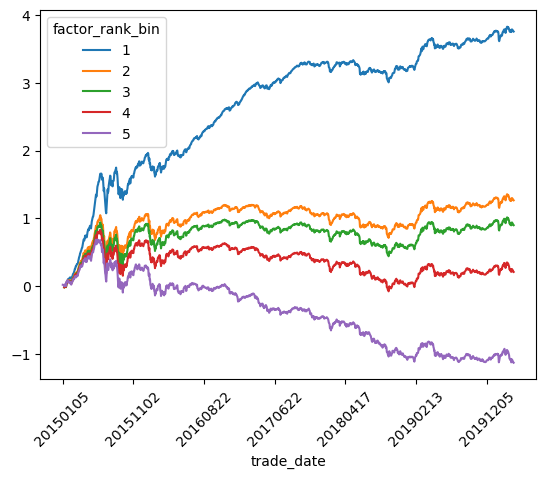

In [115]:
(alpha[alpha.trade_date > '20150101'].groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45)

<AxesSubplot:xlabel='trade_date'>

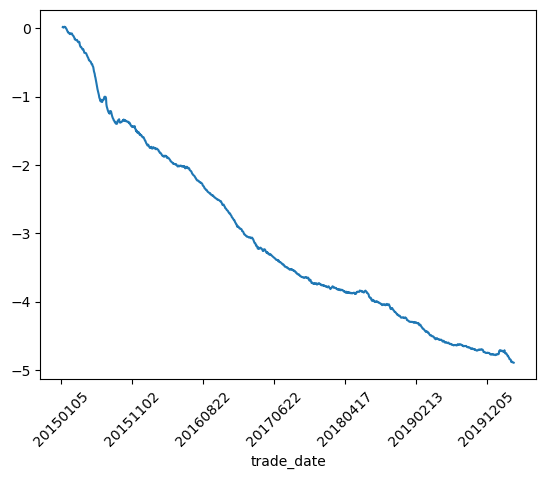

In [116]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (alpha[(alpha.factor_rank_bin == 5)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (alpha[(alpha.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45)

In [117]:
ret_PD = (alpha.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.0015 ).unstack().T

if ret_PD[1.0].mean()>ret_PD[5.0].mean():
    ret_PD['diff'] = ret_PD[1.0] - ret_PD[5.0]
else:
    ret_PD['diff'] = ret_PD[5.0] - ret_PD[1.0]


In [118]:
def cal_sell_turnover(tmp):
    stock = pd.DataFrame(tmp.groupby('trade_date').apply(lambda x: set(x.ts_code))).rename(columns={0:'stock_list'})
    stock['stock_list_shift1'] = stock.stock_list.shift(1)
    stock = stock.dropna()
    freq = []
    for i in range(len(stock)):
        freq.append(1 - len(stock.iloc[i]['stock_list'] & stock.iloc[i]['stock_list_shift1'])/len(stock.iloc[i]['stock_list']))
    stock['freq'] = freq
    return stock['freq'].mean()

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end


def max_dd_month(ret_PD):
    ret2_month = ret_PD.reset_index()
    ret2_month['month'] = [str(xx)[:6] for xx in ret2_month['trade_date']]    
    ret2_month = ret2_month.groupby('month')['ret'].sum()
    ret2_month = ret2_month.sort_values()
    return [ret2_month.head(1).values[0],ret2_month.head(1).index[0],\
            (ret2_month>0).sum()/len(ret2_month),ret2_month[ret2_month>=0].mean(),\
            ret2_month[ret2_month<0].mean()]

 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.366101,1.102788,0.020913,0.597494,-0.243537
1,2,-0.127381,-0.366072,0.021920,0.523101,-0.838058
2,3,-0.200107,-0.570421,0.022099,0.511355,-1.015622
3,4,-0.336726,-0.958848,0.022122,0.494910,-1.417910
4,5,-0.601397,-1.699847,0.022287,0.465936,-2.328786
5,diff,0.969523,7.477518,0.008168,0.710258,-0.037290
